# Bayesian online changepoint detection of a counting process
## A one-dimensional implementation

In [650]:
import numpy as np
import numba as nb
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import beta

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

## The flip of a coin
```
heads: 1
tails: 0
```

Consider a random variable $p(x \vert \mu) = {\rm Bern}(x \vert \mu) = \mu ^ x\,(1 - \mu)^{1 - x}$

In [594]:
p = 0.3 # unknown probability
n_samples = 100
np.random.seed(314)
flips = np.random.choice(2, n_samples, p=np.array([1 - p, p]))
flips

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Is the coin biased?
Consider a Beta prior on the probability of a tails

$$
    {\rm Beta}(\mu \vert a, b) = \frac{\Gamma(a)\,\Gamma(b)}{\Gamma(a + b)} \mu^{a - 1}\,(1 - \mu)^{b - 1}
$$

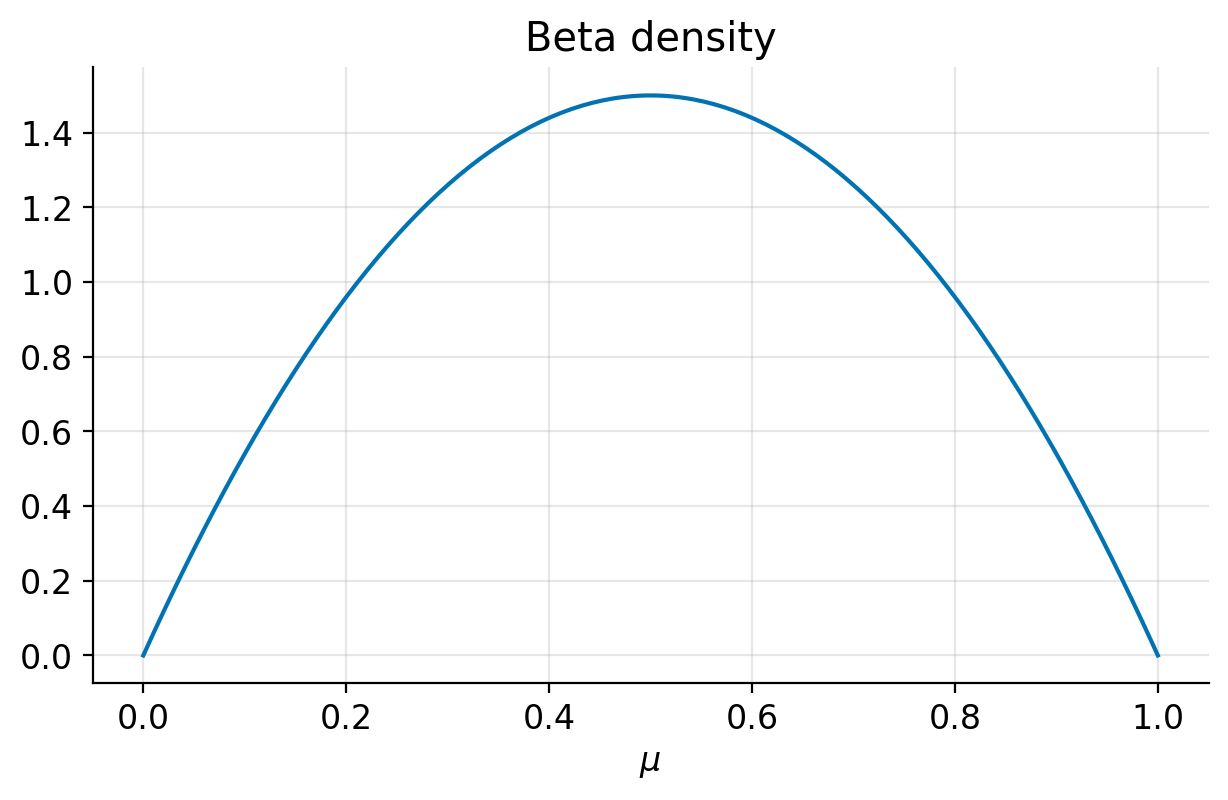

In [683]:
mu_vals = np.linspace(0, 1, 200)

a, b = 2, 2
density = beta.pdf(mu_vals, a=a, b=b)
plt.plot(mu_vals, density)
plt.title("Beta density")
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)

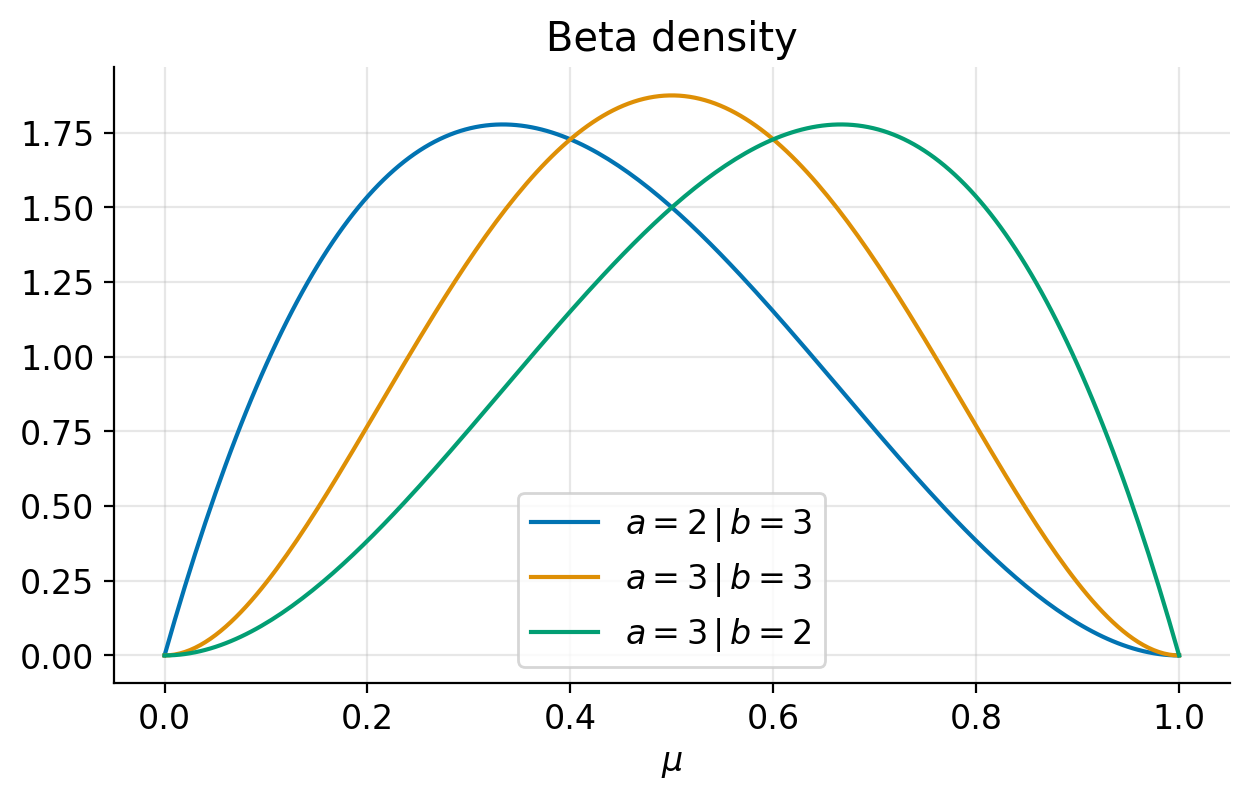

In [684]:
mu_vals = np.linspace(0, 1, 200)

a, b = 3, 3
ab_vals = [(2, 3), (3, 3), (3, 2)]
for a,b in ab_vals:
    density = beta.pdf(mu_vals, a=a, b=b)
    plt.plot(mu_vals, density, label=f"${a=} \,|\, {b=}$")
plt.title("Beta density")
plt.legend()
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)
plt.savefig("./figures/beta-density.png", dpi=300, bbox_inches="tight")

We seek to find the density of the probability the toss of a coin,
conditioned on the measurements.
At $t=1$, we have
$$
\begin{aligned}
    p(\mu \vert y_{1})
    &\propto p(\mu)\,p(y_1 \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_0, b_0)\,{\rm Bern}(y_1 \vert \mu)\\
    & \propto \mu^{a_0 - 1}\,(1 - \mu)^{b_0 - 1}\,\mu^{y_1}\,(1 - \mu)^{1 - y_1}\\
    & =\mu^{a_0 + y_1 - 1}\,(1 - \mu)^{b_0 + (1 - y_1) - 1}\\
    & = \mu^{a_1 - 1}\,(1 - \mu)^{b_1 - 1}\\
    &= {\rm Beta}(\mu \vert a_1, b_1),
\end{aligned}
$$
with $a_1 = a_0 + y_1$ and $b_1 = b_0 + (1 - y_1)$.

Following an inductive argument,
suppose $t > 1$ and $p(\mu \vert y_{1:t-1}) = {\rm Beta}(\mu \vert a_{t-1}, b_{t-1})$.
Then,
$$
\begin{aligned}
    p(\mu \vert y_{1:t})
    &\propto p(\mu \vert y_{1:t-1})\,p(y_t \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_{t-1}, b_{t-1})\,{\rm Bern}(y_t \vert \mu)\\
    &= {\rm Beta}(\mu \vert a_t, b_t),
\end{aligned}
$$

with $a_t = a_{t-1} + y_t$ and $b_1 = b_{t-1} + (1 - y_t)$.

## A first experiment

In [793]:
p = 0.3 # unknown probability
n_samples = 100
np.random.seed(314)
flips = np.random.choice(2, n_samples, p=np.array([1 - p, p]))
flips

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [794]:
a_prior, b_prior = 3, 3
a_est = a_prior
b_est = b_prior

a_vals = np.zeros_like(flips)
b_vals = np.zeros_like(flips)

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    a_vals[t] = a_est
    b_vals[t] = b_est

expected_probability = a_est / (a_est + b_est)
expected_probability

0.3018867924528302

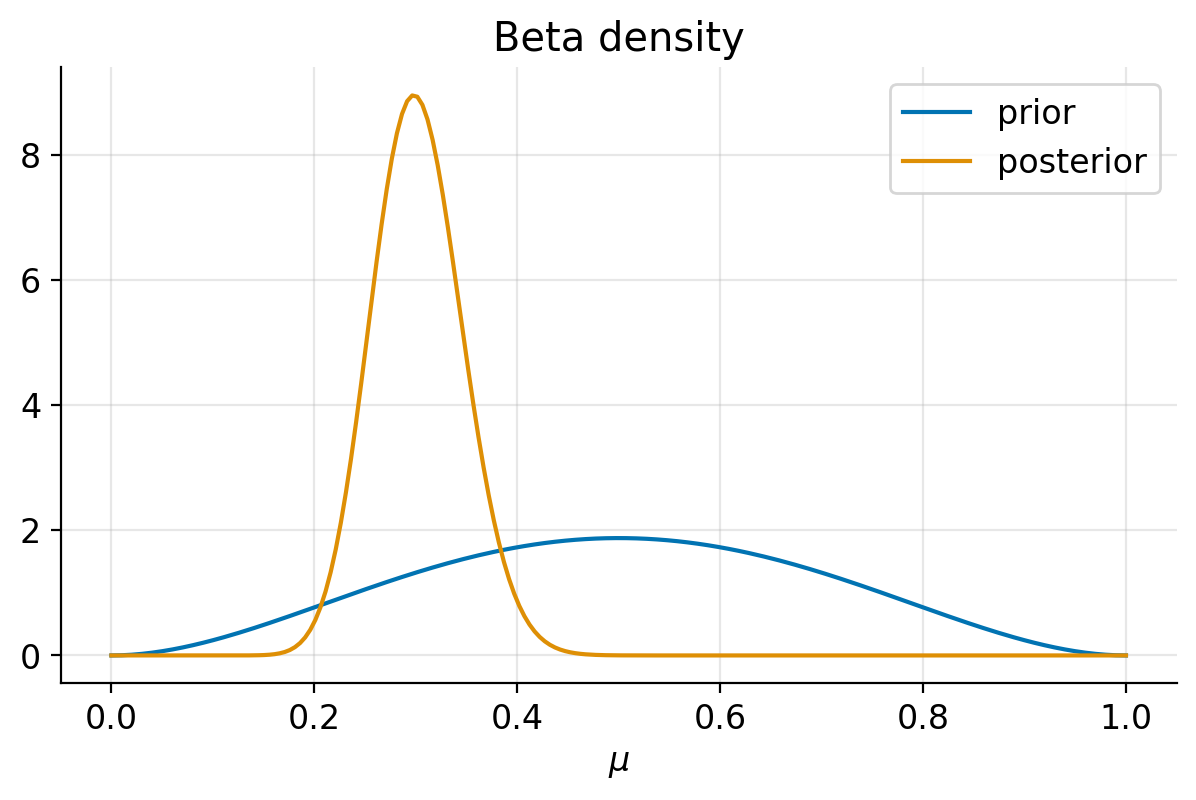

In [795]:
density_prior = beta.pdf(mu_vals, a=a_prior, b=b_prior)
density_posterior = beta.pdf(mu_vals, a=a_est, b=b_est)
plt.plot(mu_vals, density_prior, label="prior")
plt.plot(mu_vals, density_posterior, label="posterior")
plt.legend()
plt.title("Beta density")
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)

In [796]:
prior = beta(a=a_prior, b=b_prior)
prior.interval(0.95)

(0.14663279963467318, 0.8533672003653268)

In [797]:
posterior = beta(a=a_est, b=b_est)
posterior.interval(0.95)

(0.21867158129203312, 0.39218257171147397)

### Transition plot

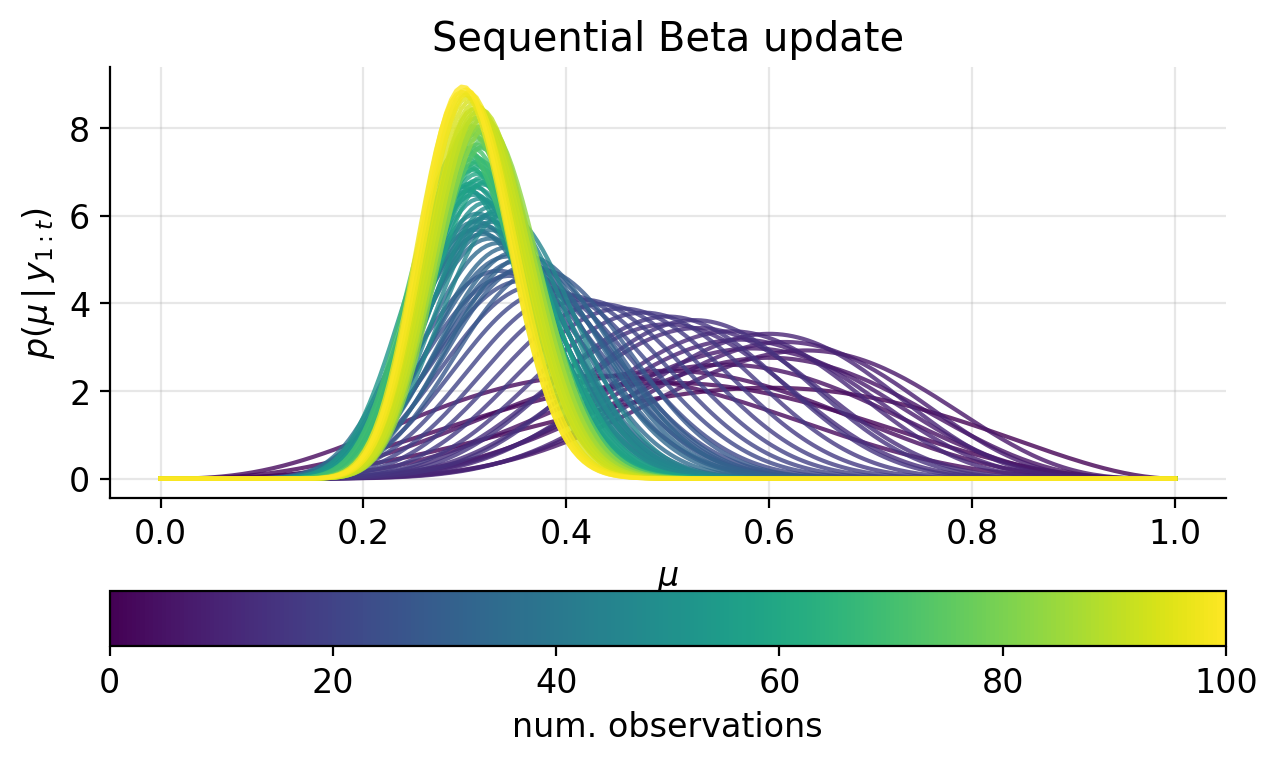

In [798]:
density_prior = beta.pdf(mu_vals, a=a_prior, b=b_prior)

fig, ax = plt.subplots()
# plt.plot(mu_vals, density_prior, label="prior", c="crimson", zorder=0, linewidth=2)

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(flips)))
norm = mpl.colors.Normalize(vmin=0, vmax=n_samples)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(
    mappable, ax=ax, orientation="horizontal", label="num. observations"
)


for t, (a_est, b_est) in enumerate(zip(a_vals, b_vals)):
    density_posterior = beta.pdf(mu_vals, a=a_est, b=b_est)
    plt.plot(mu_vals, density_posterior, color=colors[t], alpha=0.8)
    
# plt.legend()
plt.ylabel("$p(\mu\,|\,y_{1:t})$")
plt.title("Sequential Beta update")
plt.xlabel("$\mu$")
plt.grid(alpha=0.3)
plt.savefig("./figures/beta-update.png", dpi=300, bbox_inches="tight")

(-0.05, 1.05, -0.4473563195627617, 9.394482710817995)

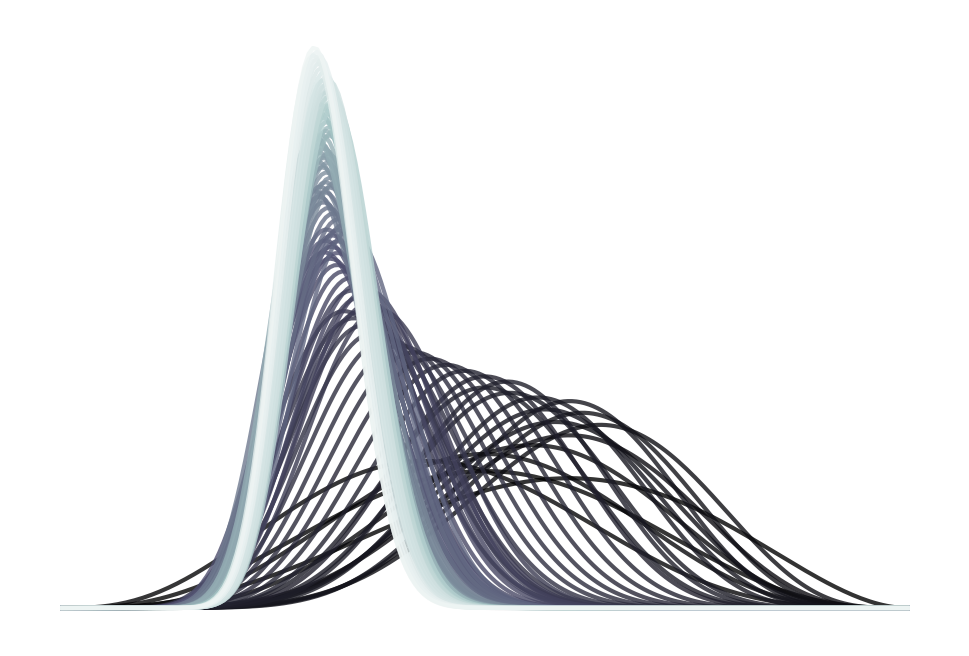

In [799]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.bone(np.linspace(0, 0.95, len(flips)))
for t, (a_est, b_est) in enumerate(zip(a_vals, b_vals)):
    density_posterior = beta.pdf(mu_vals, a=a_est, b=b_est)
    plt.plot(mu_vals, density_posterior, color=colors[t], alpha=0.8)

# ax.set_facecolor("#000000AA")
plt.axis("off")
# plt.savefig("./figures/beta-update-style.png", dpi=100, bbox_inches="tight")

We can conclude that the coin in biased.

In [800]:
# a_hist, b_hist = np.zeros((2, n_samples))
# a_hist = np.zeros(n_samples)
# b_hist = np.zeros(n_samples)

mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

In [801]:
palette = sns.color_palette()
c = palette[-3]

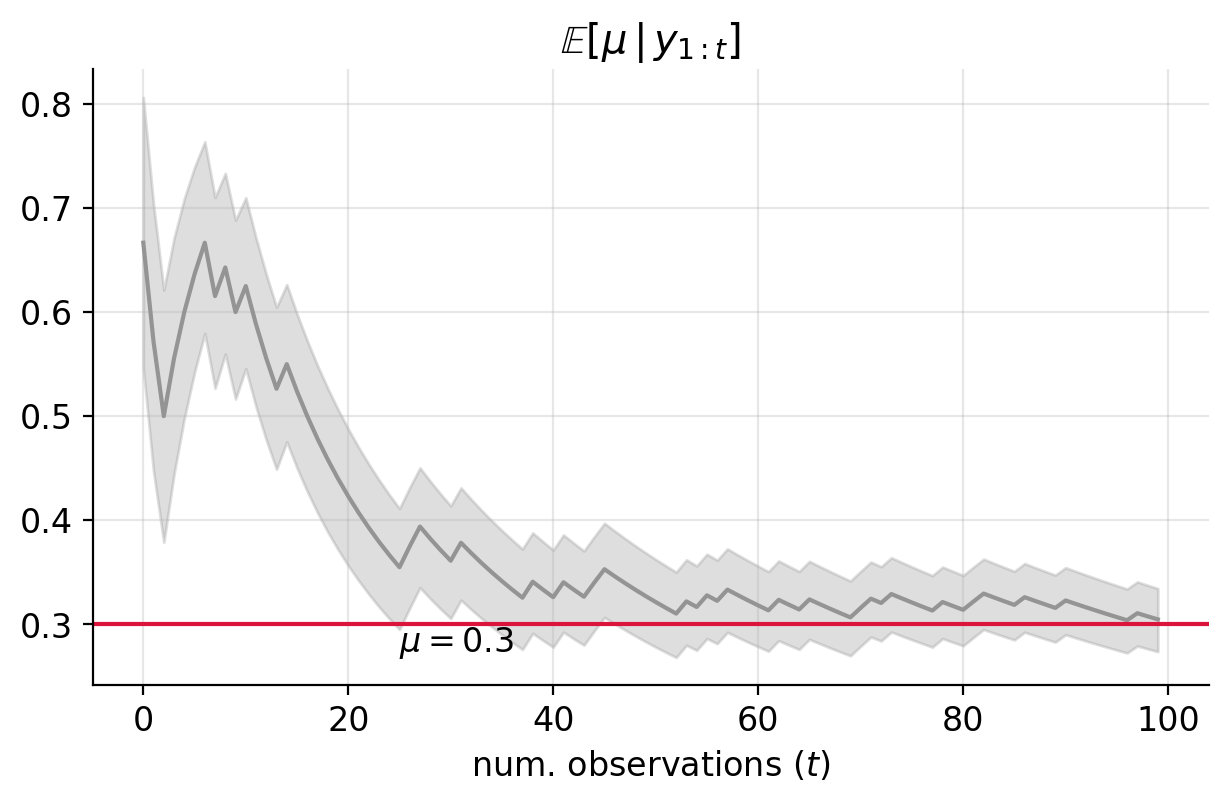

In [803]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist, c=c)
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3, color=c)
plt.xlabel("num. observations ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)
plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="top")
plt.axhline(y=0.3, c="crimson")
plt.savefig("./figures/posterior-proba-single.png", dpi=300, bbox_inches="tight")

## Change in probability
Imagine that the probability of head becomes $\mu=0.6$ after 100 steps

In [1029]:
n_samples = 200
np.random.seed(314)

p = 0.3 # unknown probability
flips_1 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

p = 0.6 # unknown probability
flips_2 = np.random.choice(2, n_samples // 2, p=np.array([1 - p, p]))

flips = np.concatenate([flips_1, flips_2])

In [1030]:
flips

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1])

In [1031]:
mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

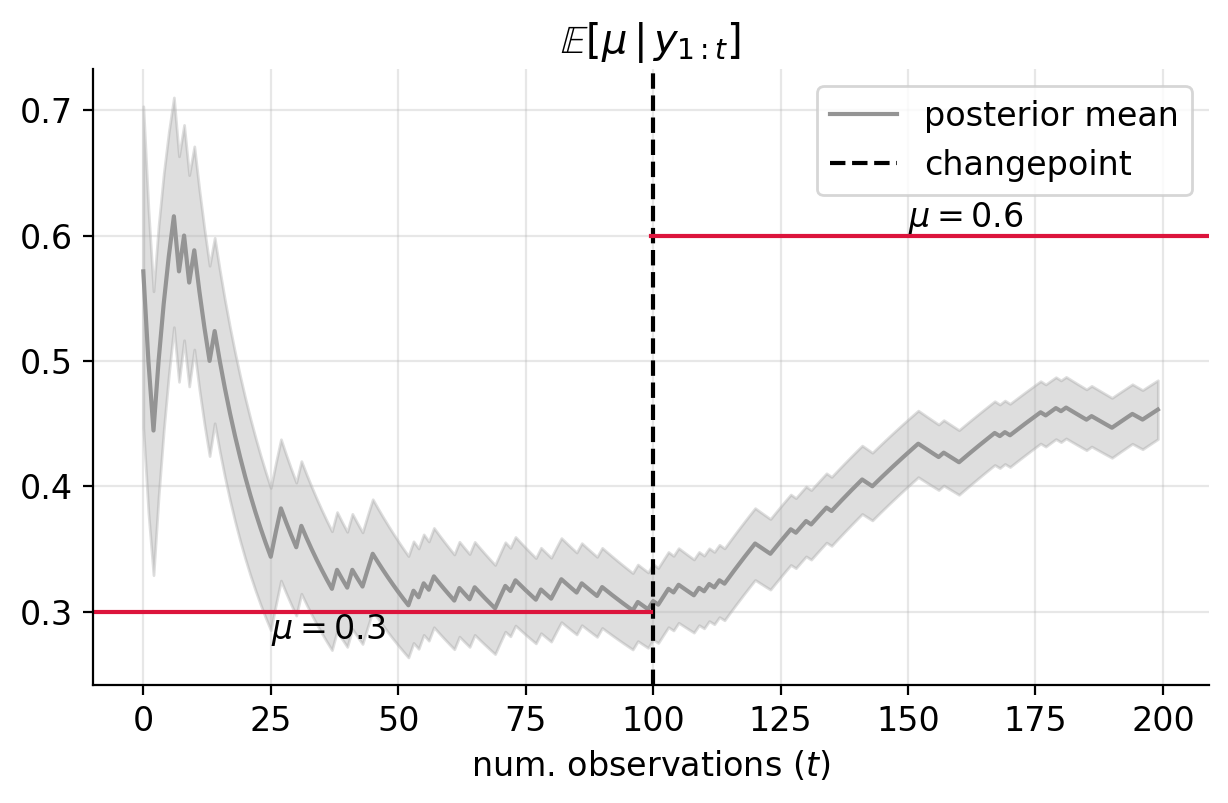

In [1032]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist, c=c, label="posterior mean")
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3, color=c)
plt.axvline(x=n_samples // 2, c="black", linestyle="--", label="changepoint")
plt.xlabel("num. observations ($t$)")
plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="top")
plt.axhline(y=0.3, xmax=0.5, c="crimson")

plt.text(150, 0.6, "$\mu = 0.6$", verticalalignment="bottom")
plt.axhline(y=0.6, xmin=0.5, c="crimson")
plt.legend()
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)
plt.savefig("./figures/posterior-proba-changepoint-naive.png", dpi=300, bbox_inches="tight")

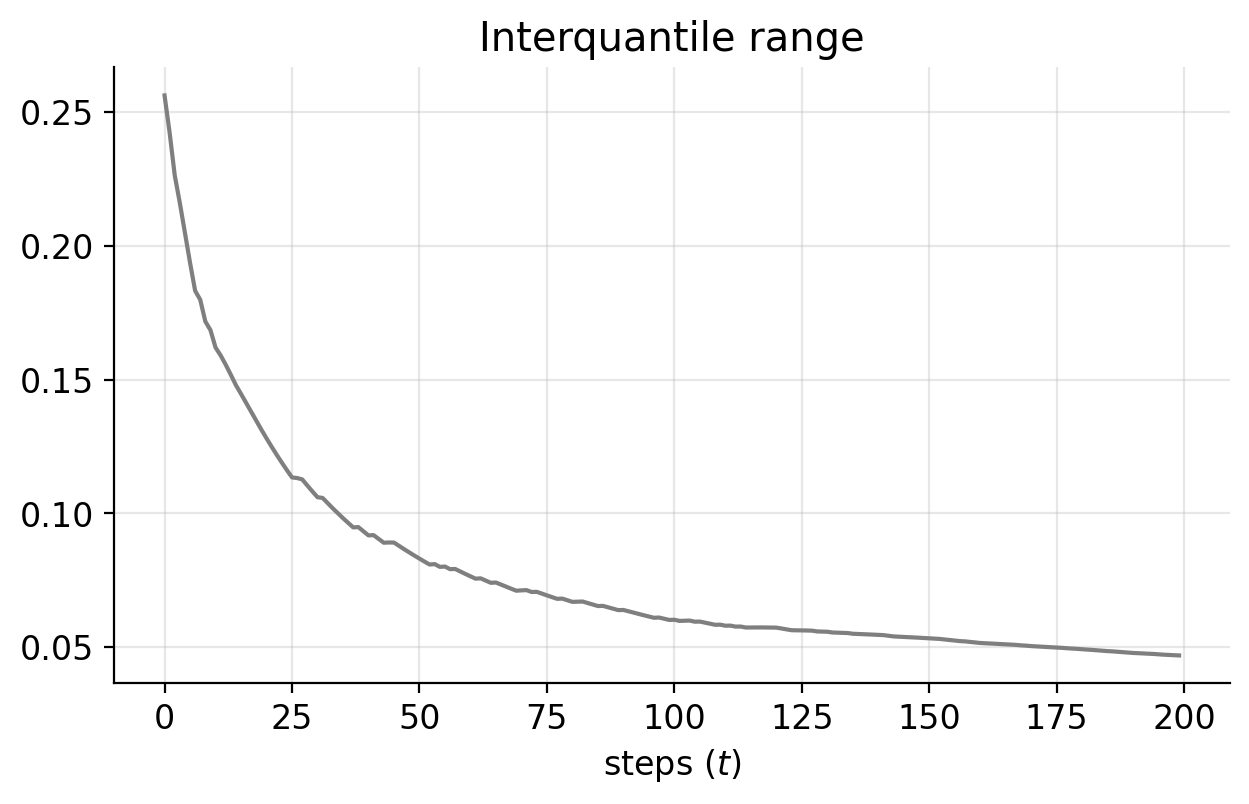

In [1033]:
plt.plot(uq_hist - lq_hist, c="tab:gray")
plt.xlabel("steps ($t$)")
plt.title(r"Interquantile range")
plt.grid(alpha=0.3)

The uncertainty decreases regardless of the change in estimate!

To overcome this, we could ask the following question:
when was the last time that a *changepoint* ocurred?
By changepoint, we mean that the values of $a$ and $b$ change.

If we were to have access to this number, then we could re-set the algorithm
with the initial estimate in mean and variance and start from $0$.

In [1034]:
mean_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

a_est = a
b_est = b

for t, flip in enumerate(flips):

    # Reset if changepoint
    if t == 100:
        a_est, b_est = a, b
    
    a_est = a_est + flip
    b_est = b_est + (1 - flip)

    mean_hist[t] = a_est / (a_est + b_est)
    
    pdensity = beta(a=a_est, b=b_est)
    lq_hist[t] = pdensity.ppf(0.25)
    uq_hist[t] = pdensity.ppf(0.75)

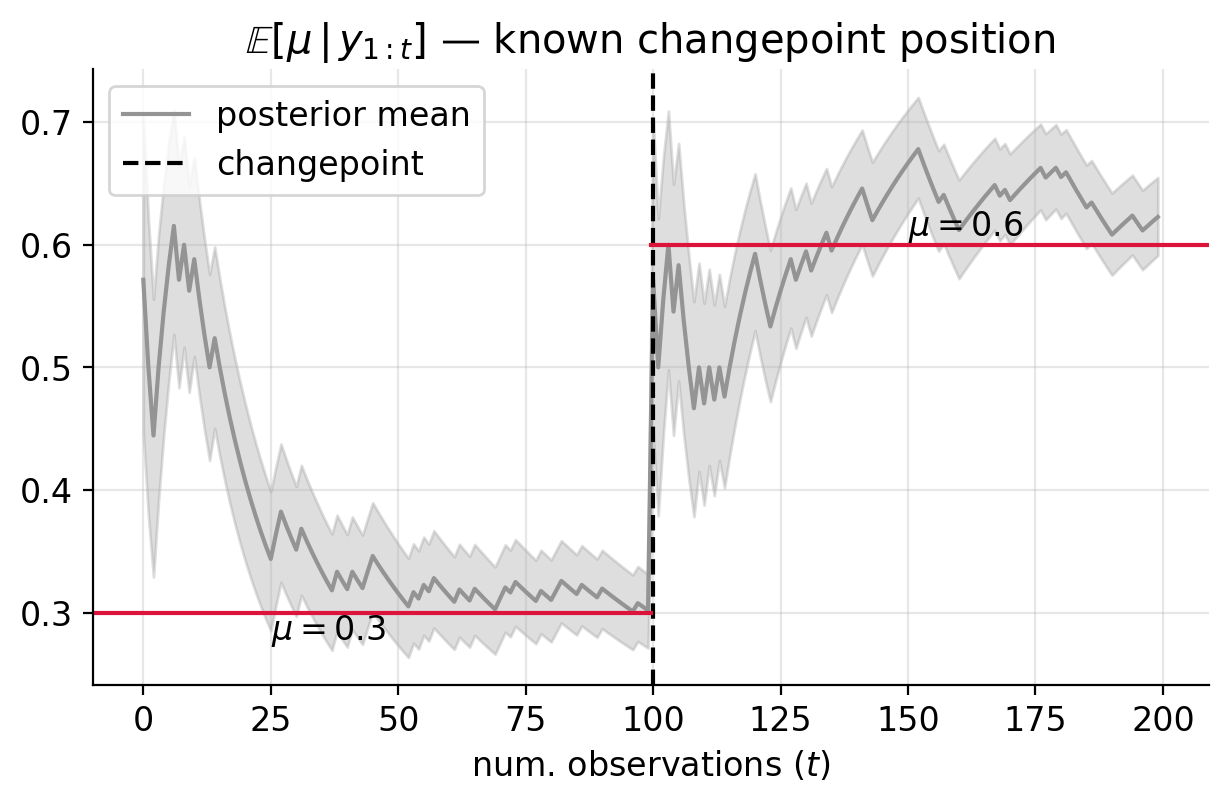

In [1035]:
steps = np.arange(n_samples)
plt.plot(steps, mean_hist, c=c, label="posterior mean")
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3, color=c)
plt.axvline(x=n_samples // 2, c="black", linestyle="--", label="changepoint")
plt.xlabel("steps ($t$)")
plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="top")
plt.axhline(y=0.3, xmax=0.5, c="crimson")
plt.text(150, 0.6, "$\mu = 0.6$", verticalalignment="bottom")
plt.axhline(y=0.6, xmin=0.5, c="crimson")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$ — known changepoint position")
plt.xlabel("num. observations ($t$)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("./figures/posterior-proba-changepoint-known.png", dpi=300, bbox_inches="tight")

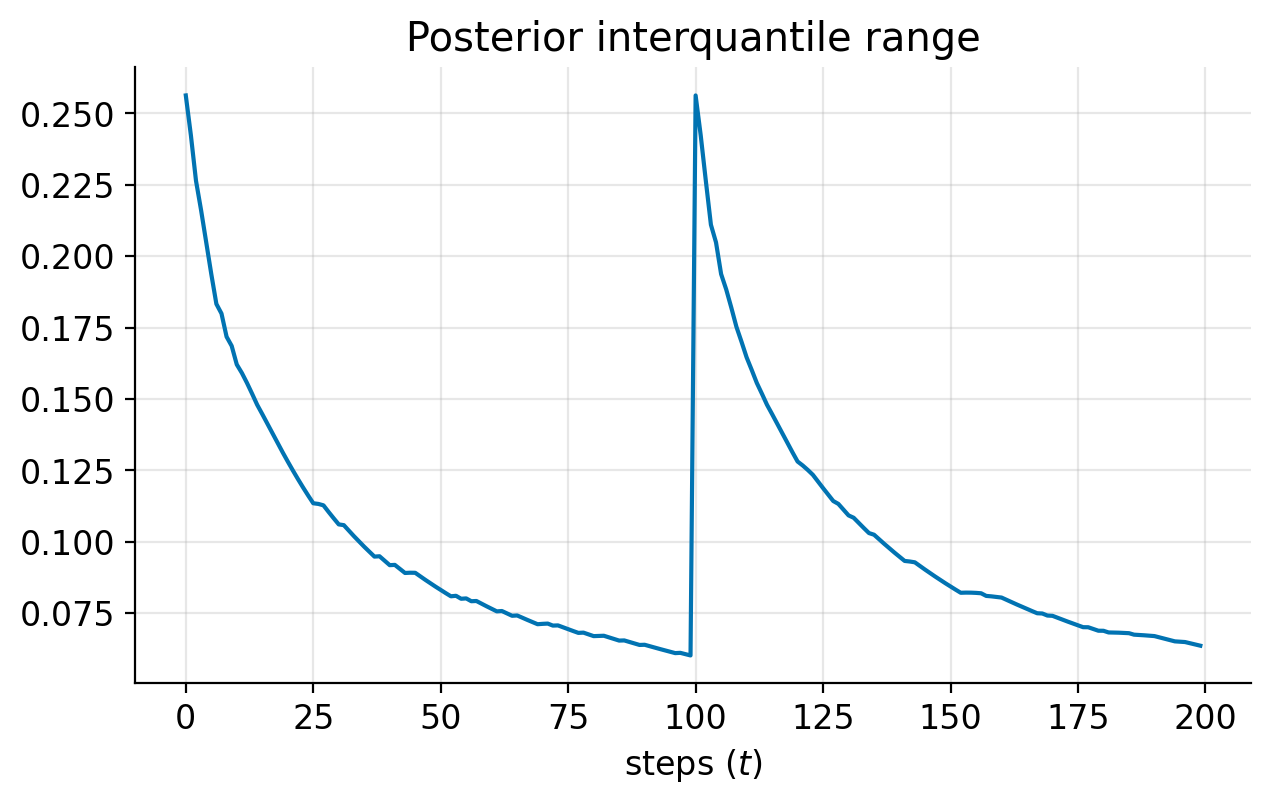

In [1036]:
plt.plot(uq_hist - lq_hist)
plt.xlabel("steps ($t$)")
plt.title(r"Posterior interquantile range")
plt.grid(alpha=0.3)

In reality, we do not have concrete evidence on the last occurence of a changepoint.
To go around this problem, we assume that the time since the last changepoint
is another random variable.
We call this variable the _runlength_ and we denote it by $r_t \in \{0, \ldots, t\}$.

$$
    p(r_t\,\vert\,y_{1:t}) = \frac{p(r_t,\,y_{1:t})}{\sum_{\ell=0}^tp(r_t=\ell, y_{1:t})}
$$

With this quantity, we define the influence on the posterior as
$$
    p(\mu \vert r_t=k, y_{1:t}) = p(\mu \vert y_{t-k:t}) = {\rm Beta}(\mu \vert a_{t-k:t}, b_{t-k:t}),
$$
with
$a_{t-k:t} = a_0 + \sum_{j=0}^k y_{t - k + j}$ and
$b_{t-k:t} = b_0 + k - \sum_{j=0}^k y_{t - k + j}$.

This last equation simply means that if a changepoint happened $k$ steps ago,
the posterior only considers the last $k$ observations, i.e.,
from $y_{t-k}$ to $y_t$.

The main quantity of interest is $p(r_t,\,y_{1:t})$ and it takes the form
$$
\begin{aligned}
p(r_t=k,\,y_{1:t})
&= \sum_{j=1}^{t-1} p(r_t = k, r_{t-1}=j, y_{1:t})\\
&= \sum_{j=1}^{t-1} p(r_t = k, r_{t-1}=j, y_{1:t-1}, y_t)\\
&= \sum_{j=1}^{t-1} p(r_{t-1}=j, y_{1:t-1})\,p(r_t=k,\,y_t\vert r_{t-1}=j, y_{1:t-1})\\
&= \sum_{j=1}^{t-1} p(r_{t-1}=j, y_{1:t-1})\,p(r_t=k,\,y_t\vert r_{t-1}=j, y_{1:t-1})\\
&= \sum_{j=0}^{t-1}
    \underbrace{
    p(r_{t-1}=j, y_{1:t-1})
    }_{({\rm A})}
    \,
    \underbrace{
    p(r_t=k,\vert r_{t-1}=j, y_{1:t-1})
    }_{({\rm B})}
    \,
    \underbrace{
    p(y_t \vert r_t=k, r_{t-1}=j, y_{1:t-1})
    }_{({\rm C})}
\end{aligned}
$$

The value of $({\rm A})$ is assumed to be computed at time $t-1$ for $j=1,\ldots, t-1$.

Next, $r_t$ is assumed to be independent on the $y_{1:t-1}$ conditioned on $r_{t-1}$. So that $(\text{B})$ becomes
$$
    p(r_t = k \vert r_{t-1} = j) =
    \begin{cases}
    H(r_t) & k = 0,\\
    1 - H(r_t) & k = j + 1,\\
    0 & \text{otherwise}.
    \end{cases}
$$

Finally, $(\text{C})$
$$
    p(y_t \vert r_t=k, r_{t-1}=j, y_{1:t-1}) = p(y_t \vert r_t=k, y_{1:t-1})
$$
with
$$
\begin{aligned}
    p(y_t \vert r_t=k, y_{1:t-1})
    &= \int p(\mu, y_t \vert r_t =k, y_{1:t-1}) {\rm d}\mu\\
    &= \int p(\mu \vert r_t =k, y_{1:t-1})\,p(y_t \vert \mu) {\rm d}\mu\\
    &= \int p(\mu \vert y_{t-1-k:t-1})\,p(y_t \vert \mu) {\rm d}\mu\\
    &= \int {\rm Beta}(\mu \vert a_{t-1-k:t-1}, b_{t-1-k:t-1})\,{\rm Bern}(y_t \vert \mu)  {\rm d}\mu\\
    &= \int
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \mu^{a_{t-1-k:t-1}}\,(1 - \mu)^{b_{t-1-k:t-1}}\,\mu^{y_t}\,(1-\mu)^{1 - y_t} {\rm d}\mu\\
    &=
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \int\mu^{a_{t-1-k:t-1}}\,(1 - \mu)^{b_{t-1-k:t-1}}\,\mu^{y_t}\,(1-\mu)^{1 - y_t} {\rm d}\mu\\
    &= 
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + y_t + 1 - y_t)}
    {\Gamma(a_{t-1-k:t-1} + y_t)\Gamma(b_{t-1-k:t-1} + 1 - y_t)}\\
    &= 
    \frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + 1)}
    {\Gamma(a_{t-1-k:t-1} + y_t)\Gamma(b_{t-1-k:t-1} + 1 - y_t)}
\end{aligned}
$$

Note that $z\Gamma(z)$ = $\Gamma(z + 1)$. Then,
$$
\begin{aligned}
    &\frac{\Gamma(a_{t-1-k:t-1} + 1)\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1} + 1)}\\
    =&\frac{\Gamma(a_{t-1-k:t-1})\Gamma(b_{t-1-k:t-1})}{\Gamma(a_{t-1-k:t-1} + b_{t-1-k:t-1})}
    \frac{a_{t-1-k:t-1}}{a_{t-1-k:t-1} + b_{t-1-k:t-1}}
\end{aligned}
$$

So that
$$
    p(y_t \vert r_t=k, y_{1:t-1})
    =\frac{a_{t-1-k:t-1}}{a_{t-1-k:t-1} + b_{t-1-k:t-1}}
$$
for $y_t = 1$.

With these equations, we see that
$$
    p(r_{t+1} = k, y_{1:t+1}) = p(r_{t} = k-1, y_{1:t})\,(1 - H(k))\,\frac{y_{t+1}\,a_{t-k:t} + (1 - y_{t+1})\,b_{t-k:t}}{a_{t-k:t} + a_{t-k:t}}
$$
for $k > 0$ and

$$
    p(r_{t+1} = 0, y_{1:t+1}) =
    \frac{y_t\,a_{t-k:t} + (1 - y_t)\,b_{t-k:xt}}{a_{t-k:t} + a_{t-k:t}}\sum_{j=0}^t p(r_{t-1} = j, y_{1:t-1})\,H(j)
$$

## Implementation

To avoid number underflow, we compute the log-joint. We obtain

$$
\log p(r_{t+1} = k, y_{1:t+1}) = 
\log\left(\frac{y_{t+1}\,a_{t-k:t} + (1 - y_{t+1})\,b_{t-k:t}}{a_{t-k:t} + b_{t-k:t}}\right) + 
\begin{cases}
    \log p(r_{t} = k-1, y_{1:t}) + \log(1 - H(k)) & k > 0,\\
    \log\sum_{j=0}^t\exp\left(\log p(r_t = j, y_{1:t}) + \log H(j)\right) & k = 0.
\end{cases}
$$

## Cleaning the code

In [1037]:
@njit
def logsumexp(x):
    """
    See https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    """
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


@njit
def log_predict(a, b, y):
    return np.log(y * a + (1 - y) * b) - np.log(a + b)


@njit
def update_log_joint(k, y, log_joint_prev, a, b, hazard):
    log_joint = log_predict(a, b, y)
    log_joint_prev = np.asarray(log_joint_prev)
    
    if k > 0:
        log_joint = log_joint + log_joint_prev[k-1] + np.log(1 - hazard)
    else:
        log_joint = log_joint + logsumexp(log_joint_prev + np.log(hazard))

    return log_joint


@njit
def init_bocd_step(y, log_joint_prev, a, b, hazard_rate):
    k = 0
    log_joint = update_log_joint(k, y, log_joint_prev, a, b, hazard_rate)
    
    a_slice = [a]
    b_slice = [b]
    log_joint_slice = [log_joint]

    return a_slice, b_slice, log_joint_slice

@njit
def bocd_step(y, runlength, a_prev, b_prev, log_joint_prev, hazard_rate):
    # Get a and b values at the previous timestep
    a_prev = a_prev[runlength]
    b_prev = b_prev[runlength]

    log_joint = update_log_joint(runlength + 1, y, log_joint_prev, a_prev, b_prev, hazard_rate)

    a_update = a_prev + y
    b_update = b_prev + (1 - y)

    return a_update, b_update, log_joint

@njit
def bocd_process(a_prior, b_prior, hazard_rate, measurements):
    a_hist = [[a_prior]]
    b_hist = [[b_prior]]
    log_joint_hist = [[0.0]]
    
    for t in range(n_samples):
        yt = measurements[t]

        a_prev = a_hist[t]
        b_prev = b_hist[t]
        log_joint_prev = log_joint_hist[t]
    
        a_slice, b_slice, log_joint_slice = init_bocd_step(yt, log_joint_prev, a_prior, b_prior, hazard_rate)
    
        for k in range(t+1):
            a_update, b_update, log_joint = bocd_step(
                yt, k, a_prev, b_prev, log_joint_prev, hazard_rate
            )
    
            a_slice.append(a_update)
            b_slice.append(b_update)
            log_joint_slice.append(log_joint)
    
        a_hist.append(a_slice)
        b_hist.append(b_slice)
        log_joint_hist.append(log_joint_slice)

    return a_hist, b_hist, log_joint_hist

In [1212]:
a_hist, b_hist, log_joint_hist = bocd_process(
    a_prior=3, b_prior=3, hazard_rate=1/100, measurements=flips
)

In [1213]:
log_posterior = np.zeros((n_samples, n_samples)) * np.nan
for t in range(n_samples):
    log_posterior[t, :t+1] = np.asanyarray(log_joint_hist[t]) - logsumexp(np.asanyarray(log_joint_hist[t]))

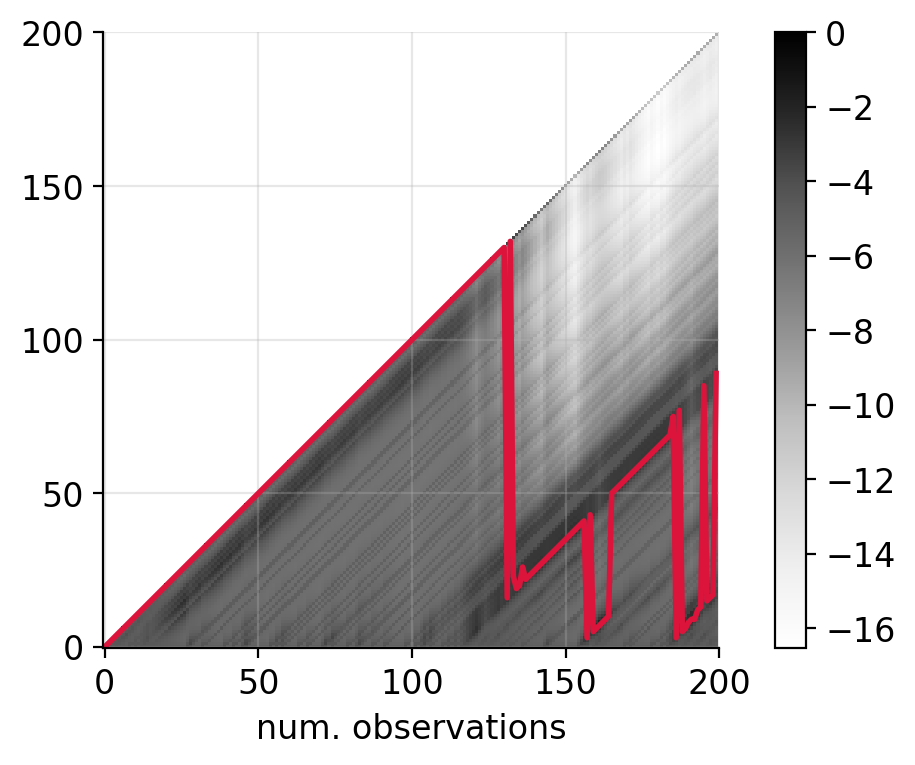

In [1214]:
plt.imshow(log_posterior.T, cmap="Grays")
plt.plot(np.nanargmax(log_posterior, axis=1), c="crimson", linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel("num. observations")
plt.grid(alpha=0.3)
ticks = [0, 50, 100, 150, 200]
plt.xticks(ticks)
plt.yticks(ticks)
plt.colorbar()
plt.savefig("./figures/bocd-log-joint-full.png", dpi=300, bbox_inches="tight")

In [1215]:
posterior = np.exp(log_posterior)

mean_est_hist = np.zeros(n_samples)
lq_hist = np.zeros(n_samples)
uq_hist = np.zeros(n_samples)

map_est_hist = np.zeros(n_samples)
map_lq_hist = np.zeros(n_samples)
map_uq_hist = np.zeros(n_samples)


for t in range(n_samples):
    a_slice = np.array(a_hist[t])
    b_slice = np.array(b_hist[t])

    posterior_t = posterior[t, :t+1]
    mean_est = a_slice / (a_slice + b_slice)

    lbound = beta(a_slice, b_slice).ppf(0.25)
    ubound = beta(a_slice, b_slice).ppf(0.75)

    map_ix = posterior_t.argmax()
    mean_est_hist[t] = (mean_est * posterior_t).sum()
    map_est_hist[t] = mean_est[map_ix]
    
    lq_hist[t] = (lbound * posterior_t).sum()
    uq_hist[t] = (ubound * posterior_t).sum()

    map_lq_hist[t] = lbound[map_ix]
    map_uq_hist[t] = ubound[map_ix]

/Users/gerardoduran/mambaforge/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


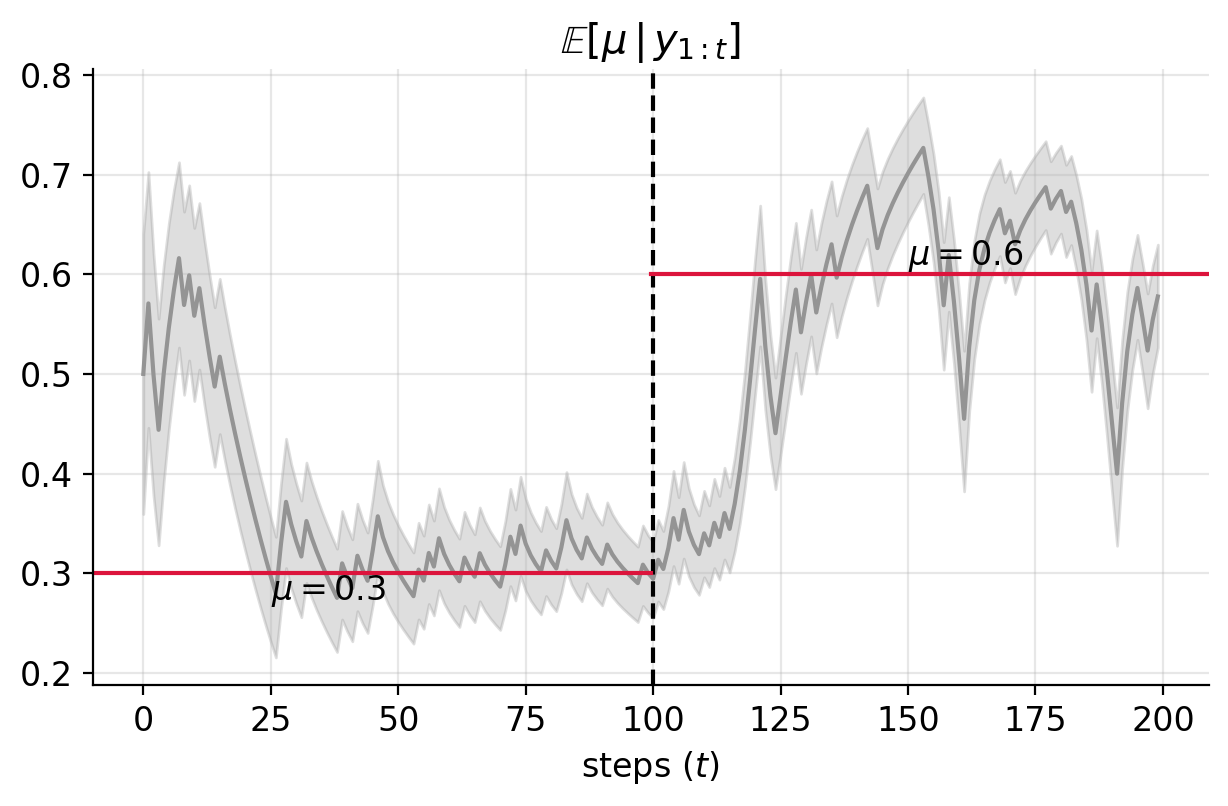

In [1216]:
steps = np.arange(n_samples)
plt.plot(steps, mean_est_hist, c=c)
plt.fill_between(steps, lq_hist, uq_hist, alpha=0.3, color=c)
plt.xlabel("steps ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")

plt.axvline(x=n_samples // 2, c="black", linestyle="--", label="changepoint")

plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="top")
plt.axhline(y=0.3, xmax=0.5, c="crimson")
plt.text(150, 0.6, "$\mu = 0.6$", verticalalignment="bottom")
plt.axhline(y=0.6, xmin=0.5, c="crimson")


plt.grid(alpha=0.3)
plt.savefig("./figures/posterior-proba-bocd-full.png", dpi=300, bbox_inches="tight")

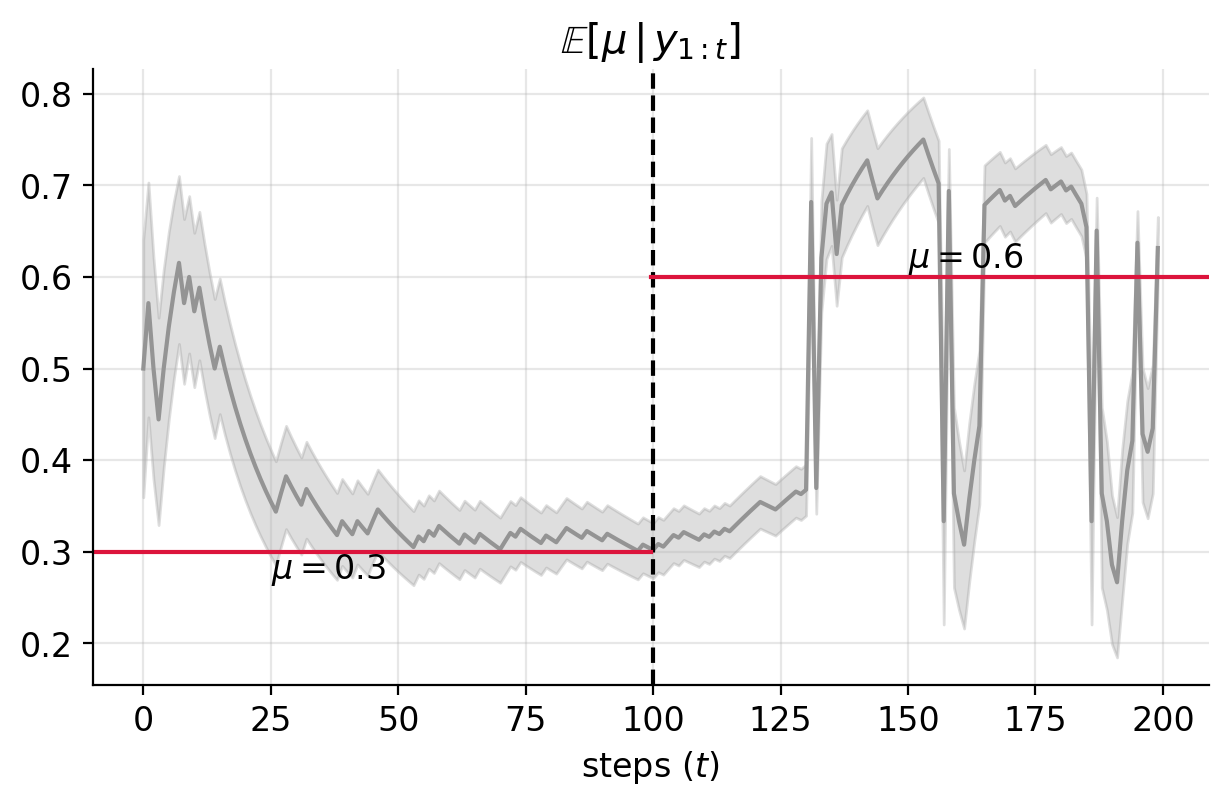

In [1217]:
steps = np.arange(n_samples)
plt.plot(steps, map_est_hist, c=c)
plt.fill_between(steps, map_lq_hist, map_uq_hist, alpha=0.3, color=c)

plt.axvline(x=n_samples // 2, c="black", linestyle="--", label="changepoint")
plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="top")
plt.axhline(y=0.3, xmax=0.5, c="crimson")
plt.text(150, 0.6, "$\mu = 0.6$", verticalalignment="bottom")
plt.axhline(y=0.6, xmin=0.5, c="crimson")


plt.xlabel("steps ($t$)")
plt.title(r"$\mathbb{E}[\mu\,\vert\,y_{1:t}]$")
plt.grid(alpha=0.3)

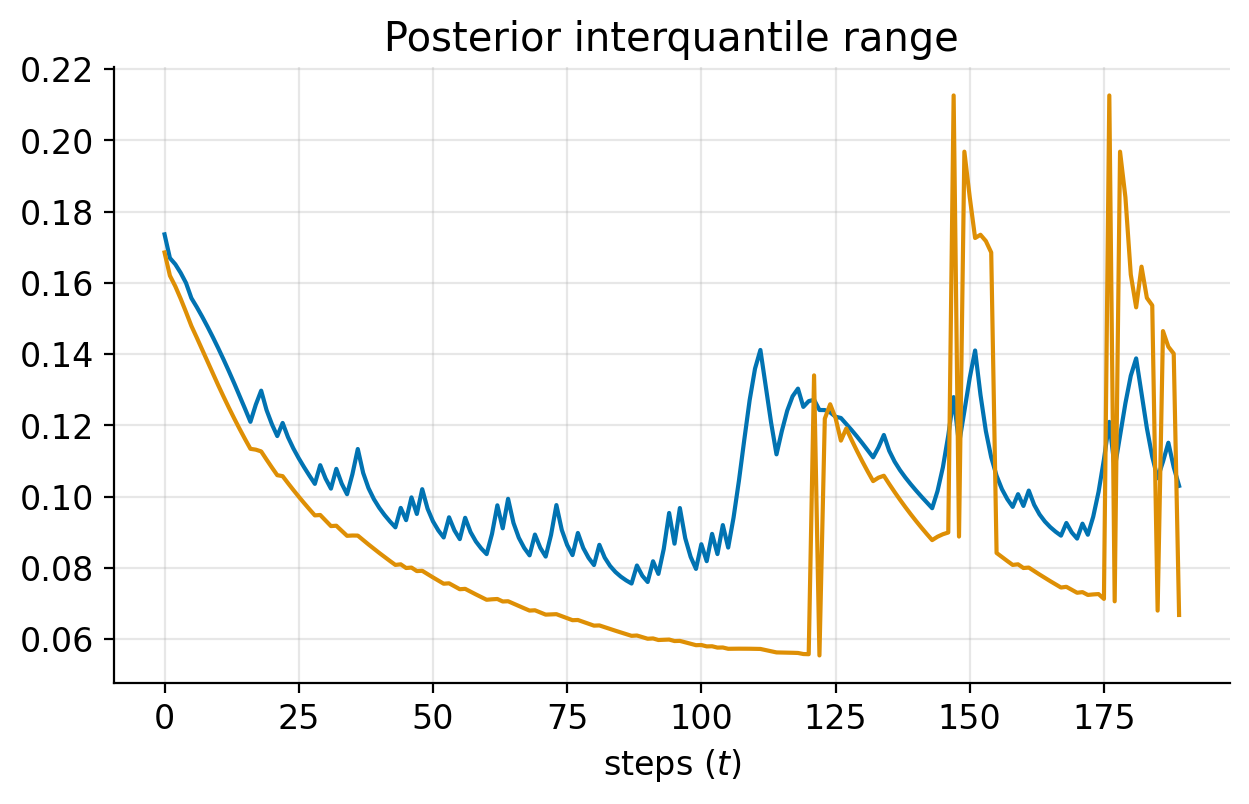

In [1218]:
plt.plot((uq_hist - lq_hist)[10:])
plt.plot((map_uq_hist - map_lq_hist)[10:])

plt.xlabel("steps ($t$)")
plt.title(r"Posterior interquantile range")
plt.grid(alpha=0.3)

## Overcoming the linear computational cost --- top $k$ hypotheses

In [1045]:
@njit
def logsumexp(x):
    """
    See https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    """
    c = x.max()
    return c + np.log(np.nansum(np.exp(x - c)))


@njit
def log_predict(a, b, y):
    return np.log(y * a + (1 - y) * b) - np.log(a + b)


@njit
def update_log_joint(k, y, log_joint_prev, a, b, hazard):
    log_joint = log_predict(a, b, y)
    log_joint_prev = np.asarray(log_joint_prev)

    if log_joint_prev[k] == -np.inf:
        return -np.inf
    
    if k > 0:
        log_joint = log_joint + log_joint_prev[k] + np.log(1 - hazard)
    else:
        log_joint = log_joint + logsumexp(log_joint_prev + np.log(hazard))

    return log_joint

@njit
def bocd_low_memory(a_prior, b_prior, hazard_rate, measurements, K):
    n_samples = len(measurements)
    a_values = np.zeros(K)
    b_values = np.zeros(K)
    log_joint_values = np.ones(K) * -np.inf
    runlengths = np.zeros(K)

    a_values_hist = np.zeros((n_samples, K))
    b_values_hist = np.zeros((n_samples, K))
    runlength_hist = np.zeros((n_samples, K))
    log_joint_hist = np.zeros((n_samples, K))

    a_values[0] = a_prior
    b_values[0] = b_prior
    log_joint_values[0] = 0.0

    a_values_hist[0] = np.ones(K) * a_prior
    b_values_hist[0] = np.ones(K) * b_prior
    runlength_hist[0] = runlengths.copy()
    log_joint_hist[0] = log_joint_values.copy()
    
    for t in range(n_samples):
        a_values_hat = np.zeros(K + 1)
        b_values_hat = np.zeros(K + 1)
        log_joint_values_hat = np.zeros(K + 1)
        runlengths_hat = np.zeros(K + 1)
        
        yt = measurements[t]

        # Initialise log-joint at k=0
        log_joint_init = update_log_joint(0, yt, log_joint_values, a_prior, b_prior, hazard_rate)
        a_values_hat[0] = a_prior
        b_values_hat[0] = b_prior
        log_joint_values_hat[0] = log_joint_init
        runlengths_hat[0] = 0

        for k in range(K):
            a_prev = a_values[k]
            b_prev = b_values[k]
            runlength = runlengths[k]

            log_joint_update = update_log_joint(k, yt, log_joint_values, a_prev, b_prev, hazard_rate)
            a_update = a_prev + yt
            b_update = b_prev + (1 - yt)

            a_values_hat[k+1] = a_update
            b_values_hat[k+1] = b_update
            log_joint_values_hat[k+1] = log_joint_update
            runlengths_hat[k+1] = runlength + 1

        topk = np.argsort(log_joint_values_hat)[::-1][:-1]
        log_joint_values = log_joint_values_hat[topk]
        log_joint_values = log_joint_values - logsumexp(log_joint_values)
        a_values = a_values_hat[topk]
        b_values = b_values_hat[topk]
        runlengths = runlengths_hat[topk]

        a_values_hist[t+1] = a_values
        b_values_hist[t+1] = b_values
        runlength_hist[t+1] = runlengths
        log_joint_hist[t+1] = log_joint_values
    
    return a_values_hist, b_values_hist, runlength_hist, log_joint_hist

In [1155]:
a_prior, b_prior = 3.0, 3.0
hazard_rate = 0.01
a_hist, b_hist, runlength_hist, log_joint_hist = bocd_low_memory(
    a_prior=a_prior, b_prior=b_prior, hazard_rate=hazard_rate, measurements=flips, K=15
)

posterior_hist = np.exp(log_joint_hist)

In [1156]:
beta_collection = beta(a_hist, b_hist)
lbounds = beta_collection.ppf(0.25)
ubounds = beta_collection.ppf(0.75)

mean_hist = beta_collection.mean()

In [1157]:
proba_est = np.einsum("tm,tm->t", mean_hist, posterior_hist)
runlenght_est = np.einsum("tm,tm->t", runlength_hist, posterior_hist)

lbound_est = np.einsum("tm,tm->t", lbounds, posterior_hist)
ubound_est = np.einsum("tm,tm->t", ubounds, posterior_hist)

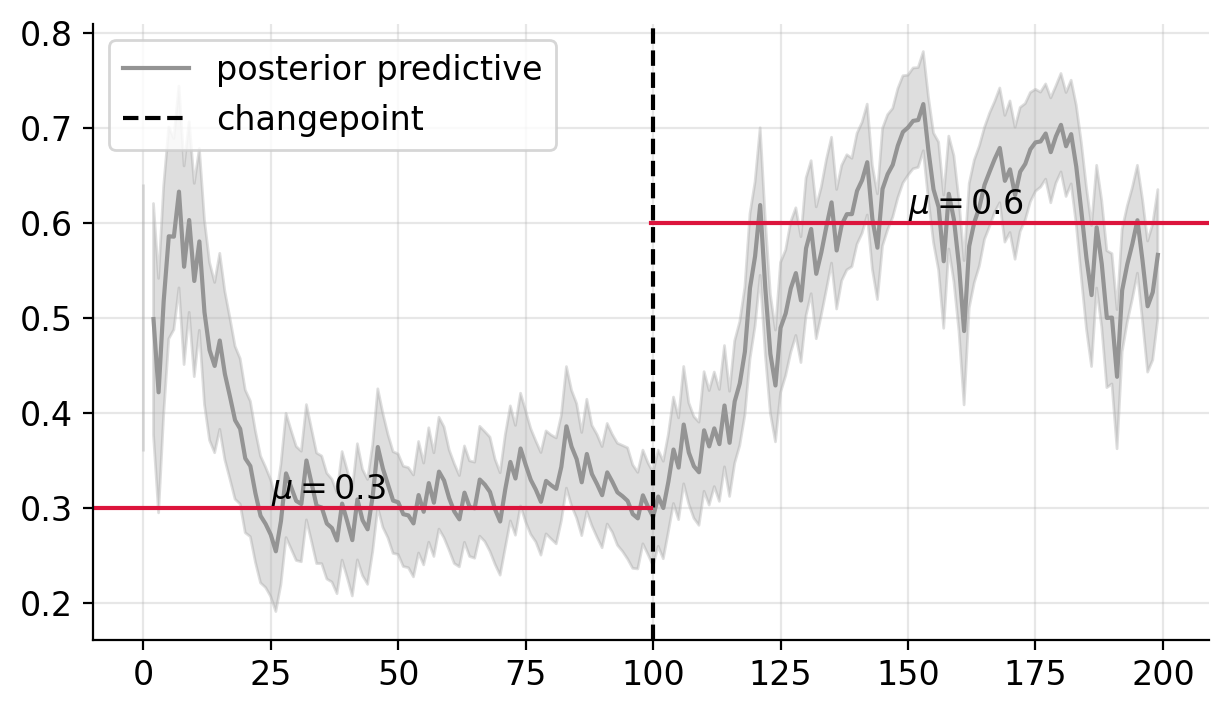

In [1182]:
plt.plot(proba_est, label="posterior predictive", c=c)
plt.fill_between(steps, lbound_est, ubound_est, color=c, alpha=0.3)

plt.axvline(x=n_samples // 2, c="black", linestyle="--", label="changepoint")
plt.text(25, 0.3, "$\mu = 0.3$", verticalalignment="bottom")
plt.axhline(y=0.3, xmax=0.5, c="crimson")
plt.text(150, 0.6, "$\mu = 0.6$", verticalalignment="bottom")
plt.axhline(y=0.6, xmin=0.5, c="crimson")

plt.legend()
plt.grid(alpha=0.3)